# Sam Jackson, MAE 494, Project 1

This code provides answers to the questions posed in Project 1. The packages used in this homework assignment are numpy, matplotlib.pyplot, and pytorch. This homework also uses a modified version of the file gp.py, which was originally made by Thomas Huijskens, and uses the packages numpy, sklearn.gausian_process, scipy.stats, and scipy.optimize .

In [1]:
# overhead

import logging
import math
import random
import numpy as np
import time
import torch as t
import torch.nn as nn
from torch import optim
from torch.nn import utils
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

In [9]:
# environment parameters

FRAME_TIME = 0.1  # time interval
GRAVITY_ACCEL = -9.81 # gravity constant (m/s^2)
BOOST_ACCEL = 15. # thrust constant (m/s^2)
ROTATION_ACCEL = 20*math.pi/180  # rotation constant (radians)

# # the following parameters are not being used in the sample code
# PLATFORM_WIDTH = 0.25  # landing platform width
# PLATFORM_HEIGHT = 0.06  # landing platform height

In [3]:
# define system dynamics
# Notes: 
# 0. You only need to modify the "forward" function
# 1. All variables in "forward" need to be PyTorch tensors.
# 2. All math operations in "forward" has to be differentiable, e.g., default PyTorch functions.
# 3. Do not use inplace operations, e.g., x += 1. Please see the following section for an example that does not work.

class Dynamics(nn.Module):

    def __init__(self):
        super(Dynamics, self).__init__()

    @staticmethod
    def forward(state, action):

        """
        action: thrust or no thrust
        state[0] = y
        state[1] = y_dot
        """
        
        # Apply gravity
        # Note: Here gravity is used to change velocity which is the second element of the state vector
        # Normally, we would do x[1] = x[1] + gravity * delta_time
        # but this is not allowed in PyTorch since it overwrites one variable (x[1]) that is part of the computational graph to be differentiated.
        # Therefore, I define a tensor dx = [0., gravity * delta_time], and do x = x + dx. This is allowed... 
        delta_state_gravity = t.tensor([0., GRAVITY_ACCEL * FRAME_TIME])

        # Thrust
        # Note: Same reason as above. Need a 2-by-1 tensor.
        delta_state = BOOST_ACCEL * FRAME_TIME * t.tensor([0., 1.]) * action

        # Update velocity
        state = state + delta_state + delta_state_gravity
        
        # Update state
        # Note: Same as above. Use operators on matrices/tensors as much as possible. Do not use element-wise operators as they are considered inplace.
        step_mat = t.tensor([[1., FRAME_TIME],
                            [0., 1.]])
        state = t.matmul(step_mat, state)

        return state

In [4]:
# a deterministic controller
# Note:
# 0. You only need to change the network architecture in "__init__"
# 1. nn.Sigmoid outputs values from 0 to 1, nn.Tanh from -1 to 1
# 2. You have all the freedom to make the network wider (by increasing "dim_hidden") or deeper (by adding more lines to nn.Sequential)
# 3. Always start with something simple

class Controller(nn.Module):

    def __init__(self, dim_input, dim_hidden, dim_output):
        """
        dim_input: # of system states
        dim_output: # of actions
        dim_hidden: up to you
        """
        super(Controller, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(dim_input, dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_output),
            # You can add more layers here
            nn.Sigmoid()
        )

    def forward(self, state):
        action = self.network(state)
        return action

In [5]:
# the simulator that rolls out x(1), x(2), ..., x(T)
# Note:
# 0. Need to change "initialize_state" to optimize the controller over a distribution of initial states
# 1. self.action_trajectory and self.state_trajectory stores the action and state trajectories along time

class Simulation(nn.Module):

    def __init__(self, controller, dynamics, T):
        super(Simulation, self).__init__()
        self.state = self.initialize_state()
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        self.action_trajectory = []
        self.state_trajectory = []

    def forward(self, state):
        self.action_trajectory = []
        self.state_trajectory = []
        for _ in range(T):
            action = self.controller.forward(state)
            state = self.dynamics.forward(state, action)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        return self.error(state)

    @staticmethod
    def initialize_state():
        state=np.array([30., 0.])
        return t.tensor(state, requires_grad=False).float()

    def error(self, state):
        for i in range(state.size(0)):
            loss = t.sum(t.square(state))
            return loss

In [6]:
# set up the optimizer
# Note:
# 0. LBFGS is a good choice if you don't have a large batch size (i.e., a lot of initial states to consider simultaneously)
# 1. You can also try SGD and other momentum-based methods implemented in PyTorch
# 2. Visualize shows the variation of each of the state variable and action variable with time
# 3. loss.backward is where the gradient is calculated (d_loss/d_variables)
# 4. self.optimizer.step(closure) is where gradient descent is done

class Optimize:
    def __init__(self, simulation):
        self.simulation = simulation
        self.parameters = simulation.controller.parameters()
        self.optimizer = optim.LBFGS(self.parameters, lr=0.01)

    def step(self):
        def closure():
            loss = self.simulation(self.simulation.state)
            self.optimizer.zero_grad()
            loss.backward()
            return loss
        self.optimizer.step(closure)
        return closure()
    
    def train(self, epochs):
        for epoch in range(epochs):
            loss = self.step()
            print('[%d] loss: %.3f' % (epoch + 1, loss))
            self.visualize()

    def visualize(self):
        statedata = np.array([self.simulation.state_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
        actiondata = np.array([self.simulation.action_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
        Time = FRAME_TIME * np.linspace(0,T,T)
        y = statedata[:, 0]
        ydot = statedata[:, 1]
        thrust = actiondata[:, 0]
        
        # Creating the plot for each of the state variables
        f1 = plt.figure()
        ax1 = f1.add_subplot(111)
        ax1.plot(Time, y, label = 'y position')
        ax1.plot(Time, ydot, label = 'ydot')
        plt.xlabel('Time, s')
        plt.ylabel('State Variables')
        plt.title('State Variables vs. Time')
        plt.grid(True)
        ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
        
        # Creating the plot for each of the action variables
        f2 = plt.figure()
        ax2 = f2.add_subplot(111)
        ax2.plot(Time, thrust, label = 'thrust')
        plt.xlabel('Time, s')
        plt.ylabel('Action Variables')
        plt.title('Action Variables vs. Time')
        plt.grid(True)
        ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
        
        plt.show()

[1] loss: 684.333


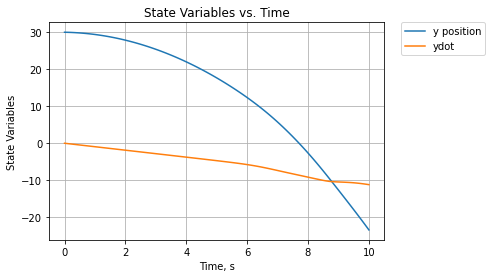

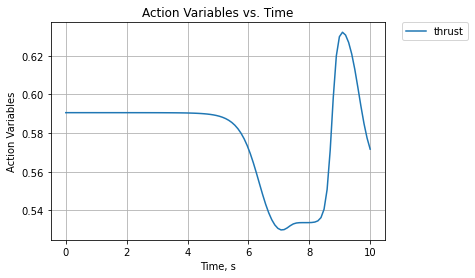

[2] loss: 380.061


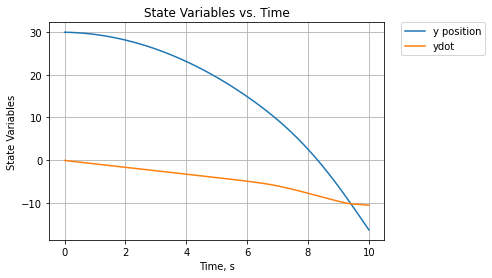

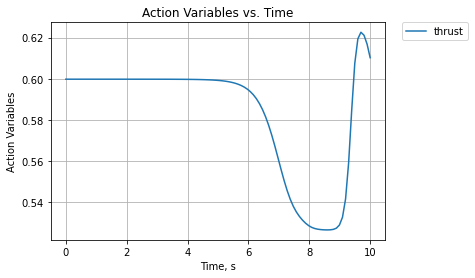

[3] loss: 243.197


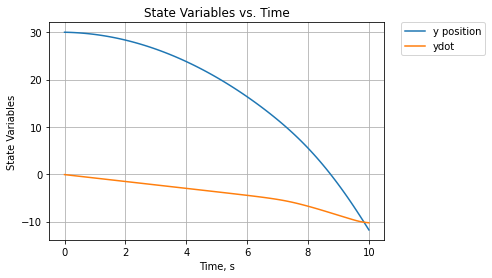

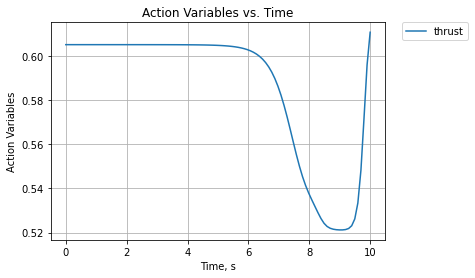

[4] loss: 145.750


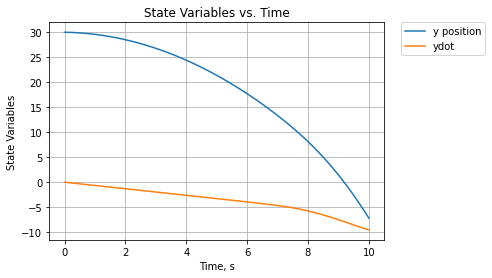

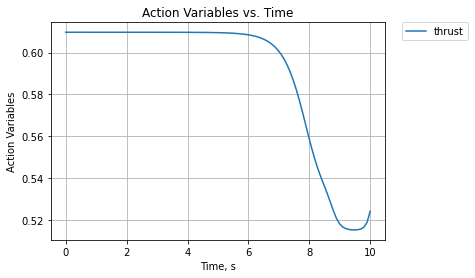

[5] loss: 110.444


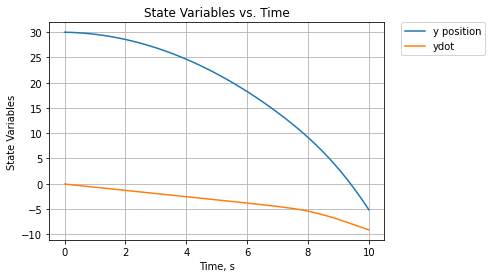

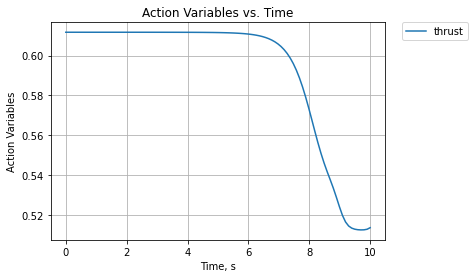

[6] loss: 90.315


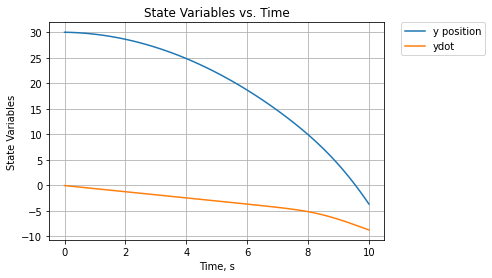

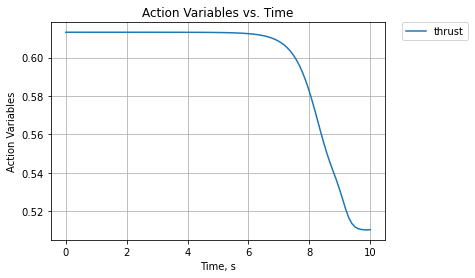

[7] loss: 77.413


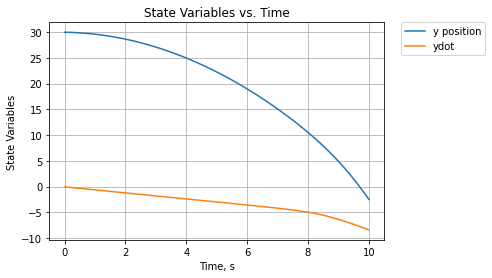

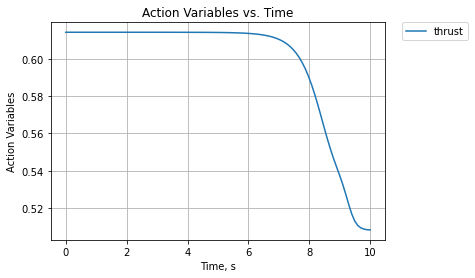

[8] loss: 68.903


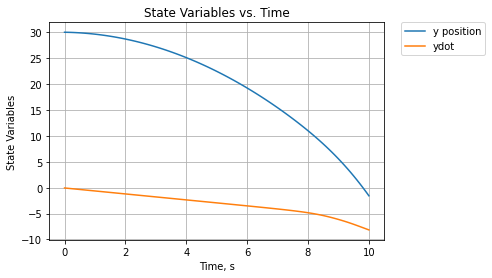

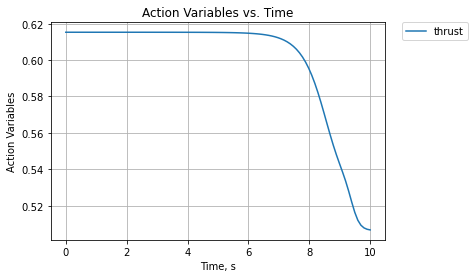

[9] loss: 63.175


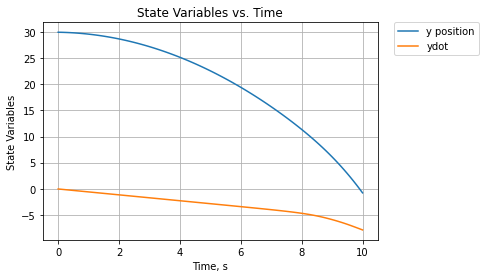

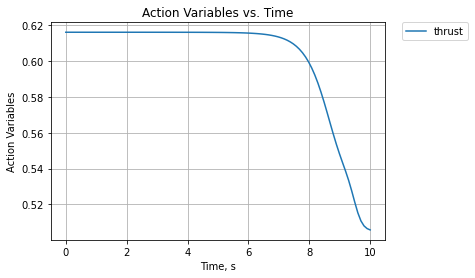

[10] loss: 59.222


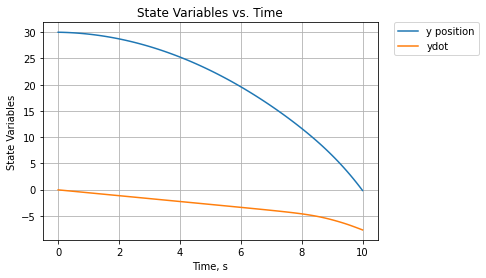

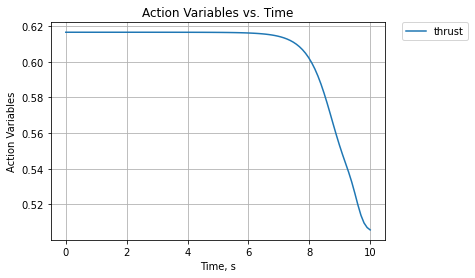

[11] loss: 56.405


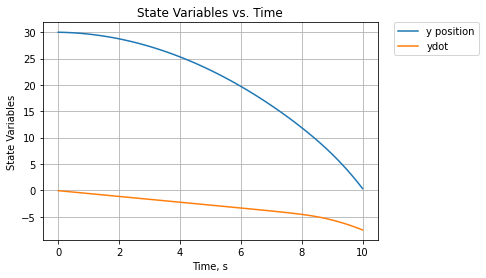

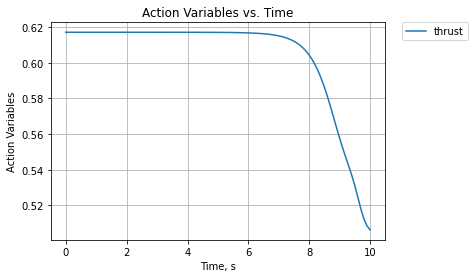

[12] loss: 54.317


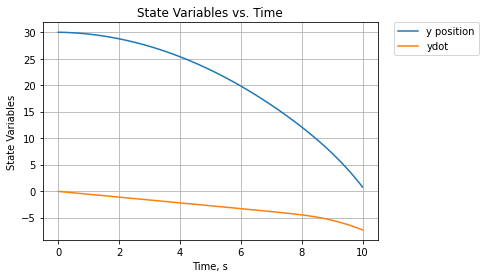

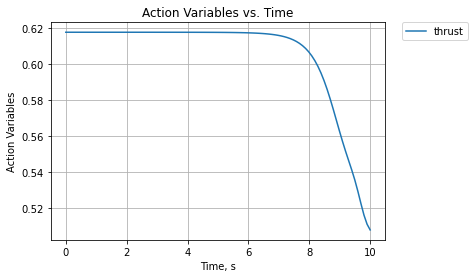

[13] loss: 52.698


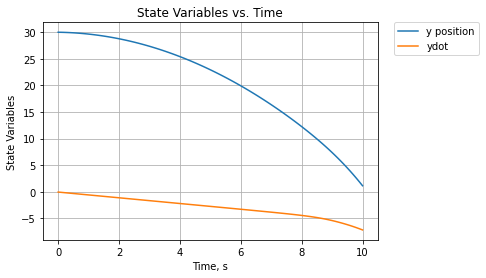

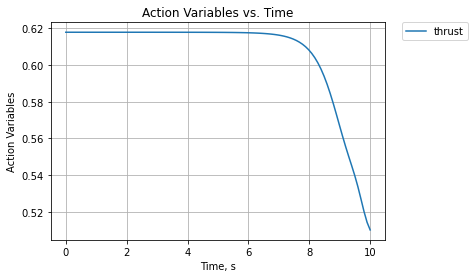

[14] loss: 51.397


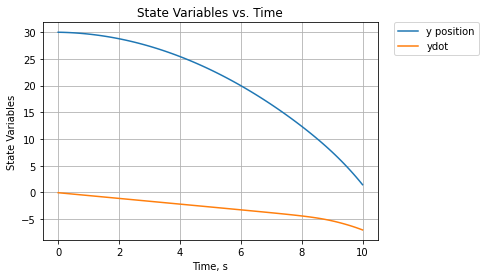

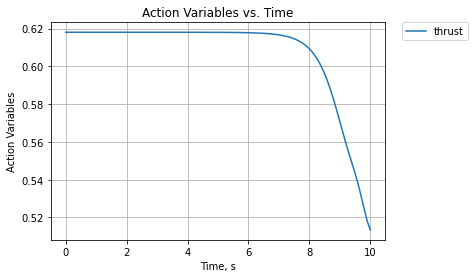

[15] loss: 50.325


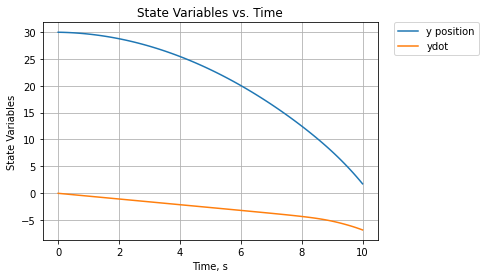

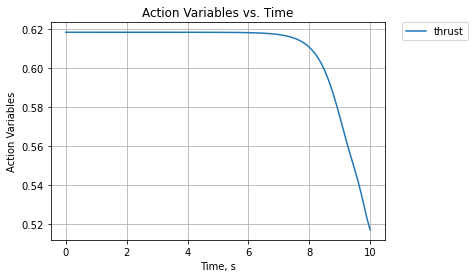

[16] loss: 49.333


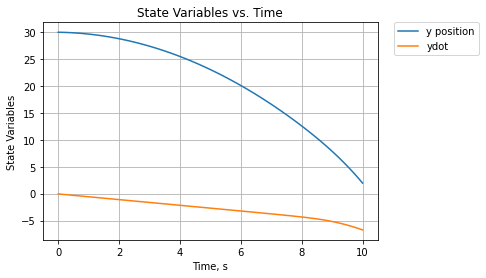

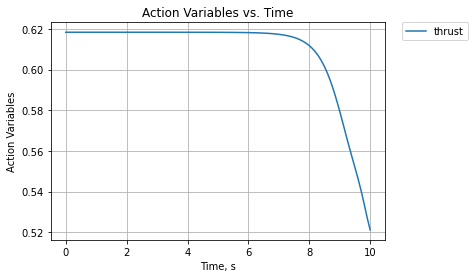

[17] loss: 47.933


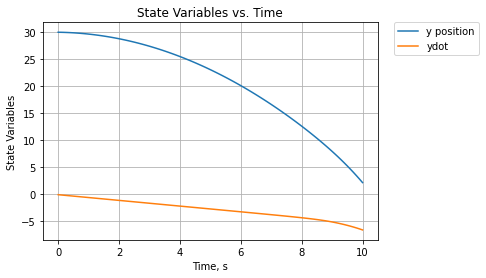

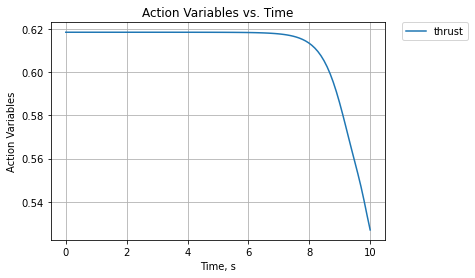

[18] loss: 44.835


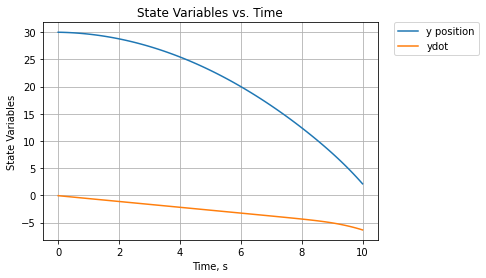

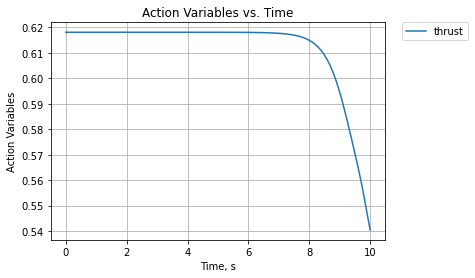

[19] loss: 18.530


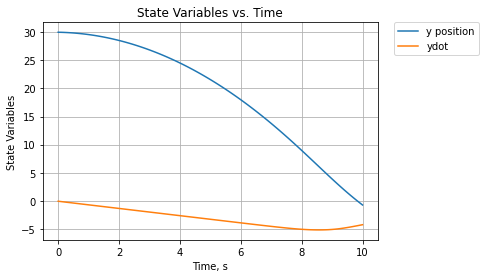

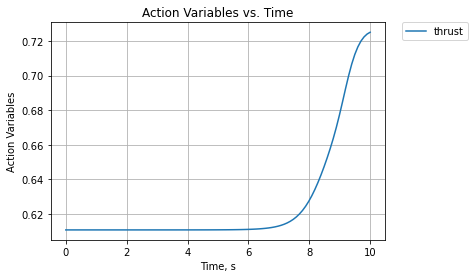

[20] loss: 7.885


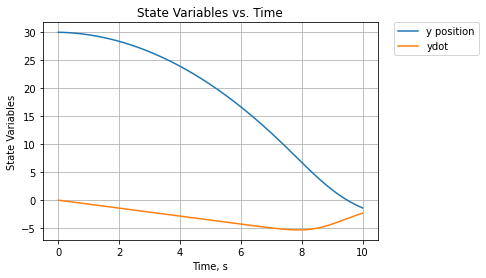

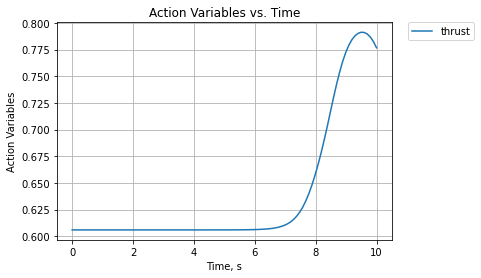

[21] loss: 4.168


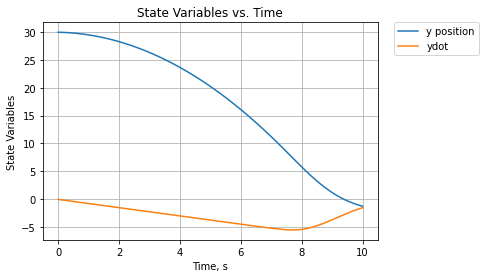

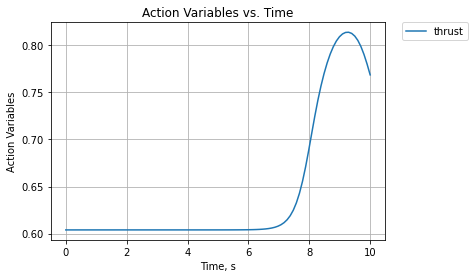

[22] loss: 2.492


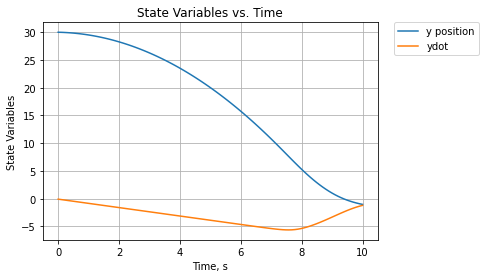

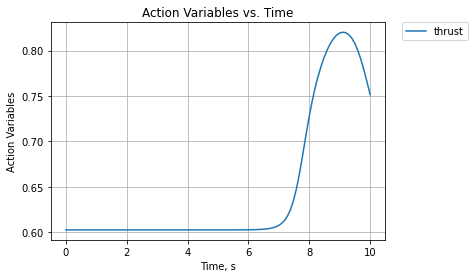

[23] loss: 1.618


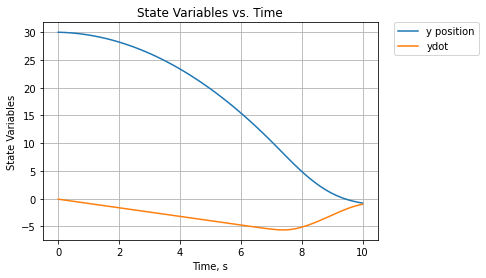

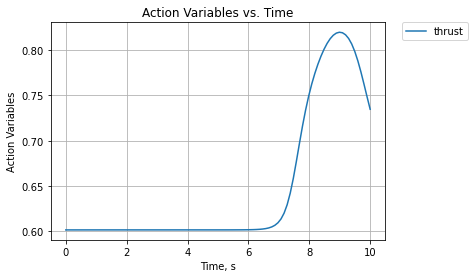

[24] loss: 1.101


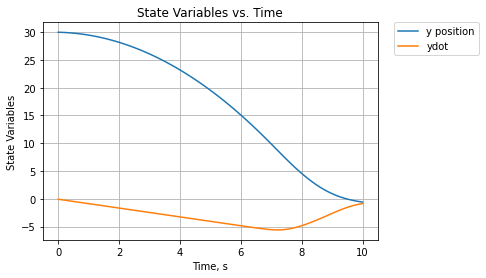

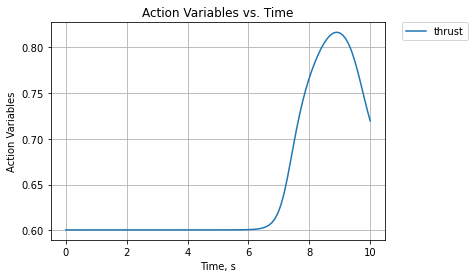

[25] loss: 0.762


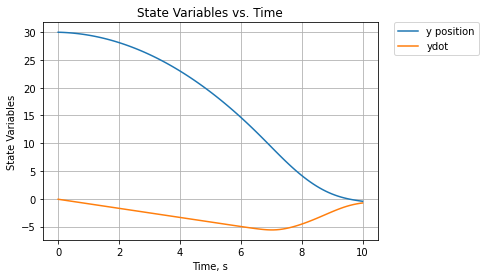

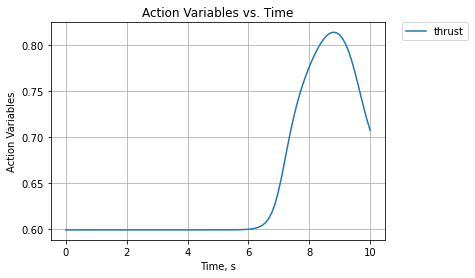

[26] loss: 0.496


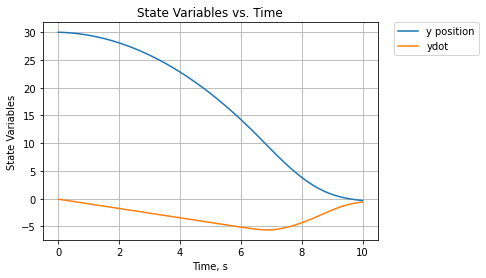

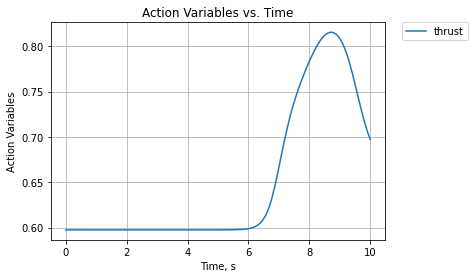

[27] loss: 0.285


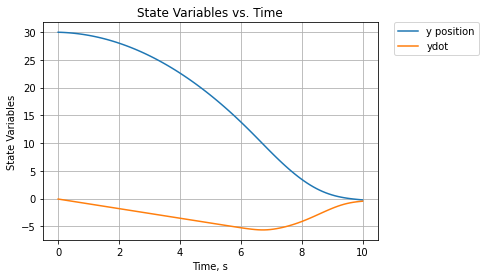

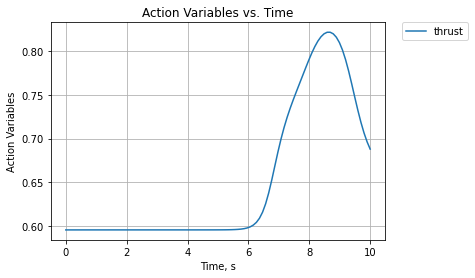

[28] loss: 0.183


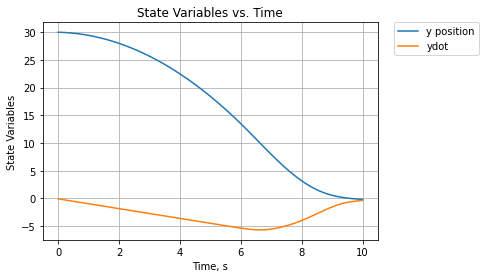

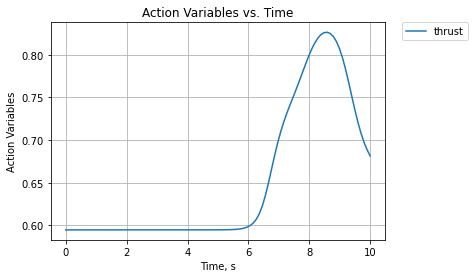

[29] loss: 0.115


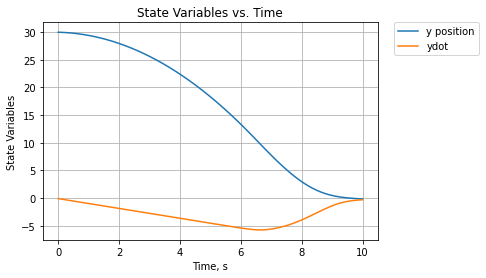

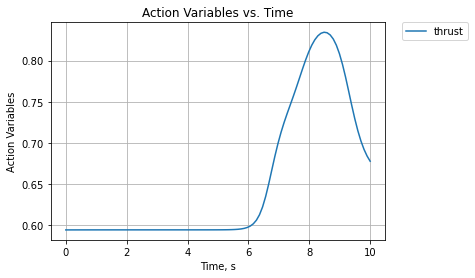

[30] loss: 0.064


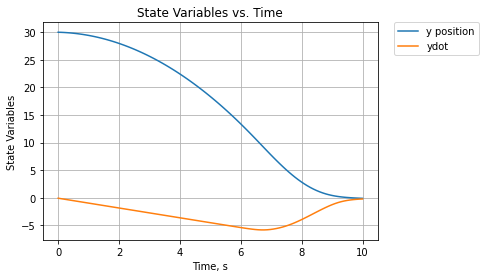

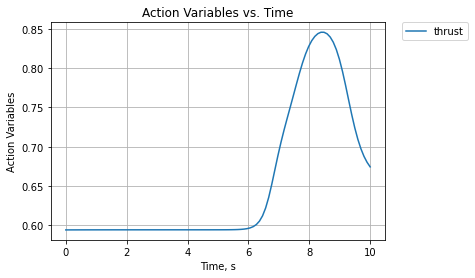

[31] loss: 0.037


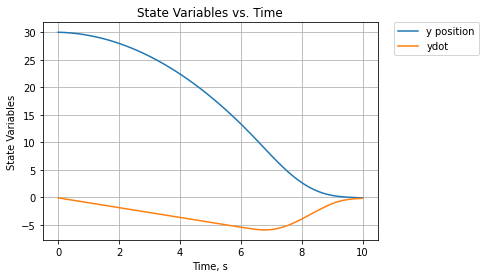

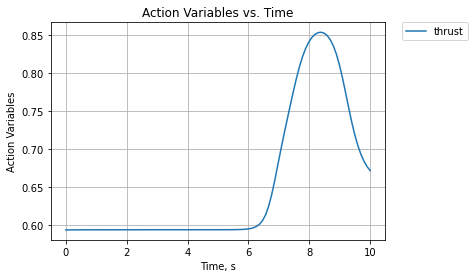

[32] loss: 0.022


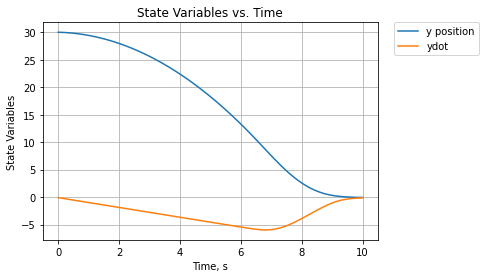

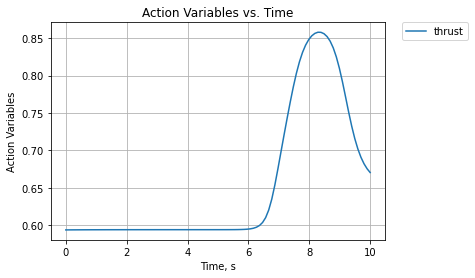

[33] loss: 0.013


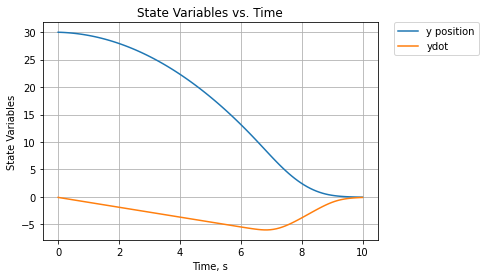

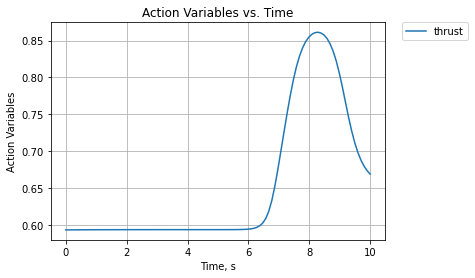

[34] loss: 0.007


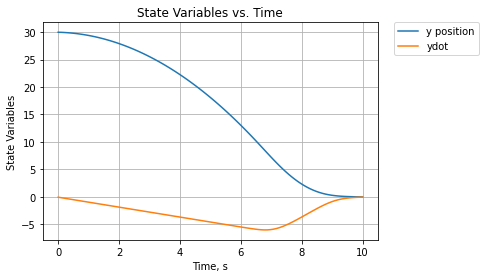

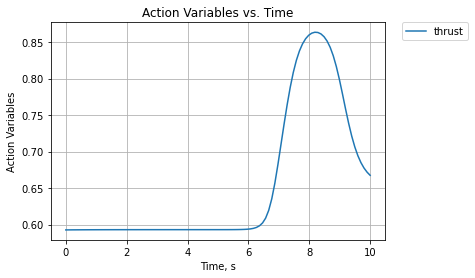

[35] loss: 0.004


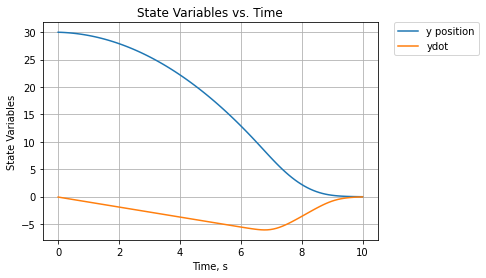

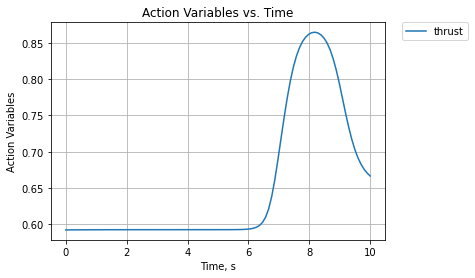

[36] loss: 0.003


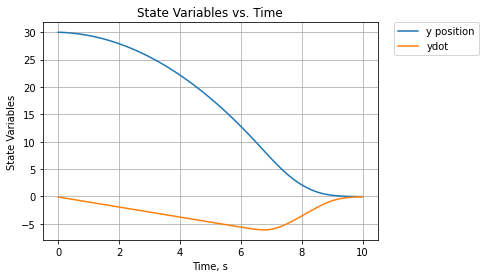

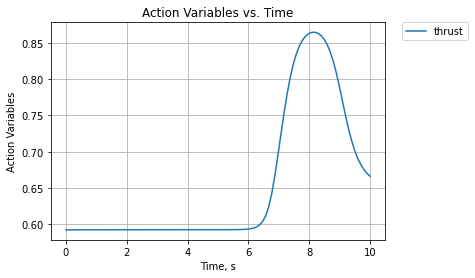

[37] loss: 0.002


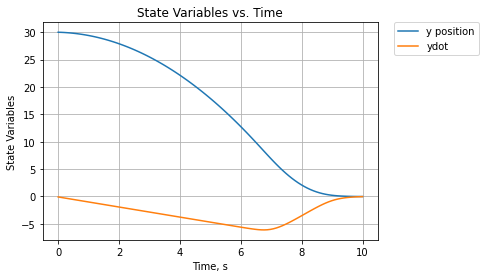

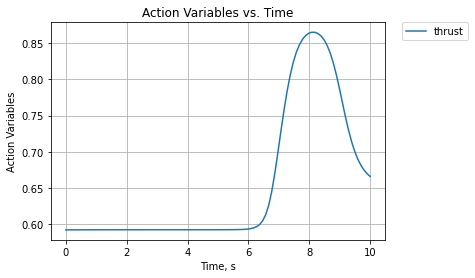

[38] loss: 0.001


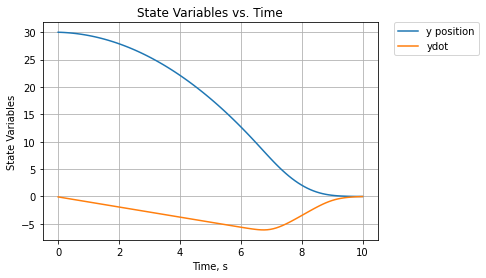

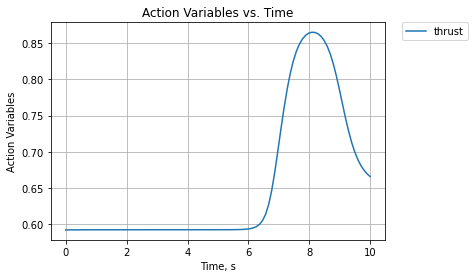

[39] loss: 0.001


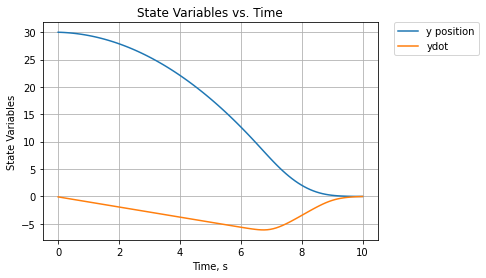

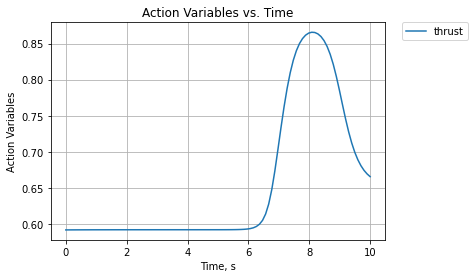

[40] loss: 0.000


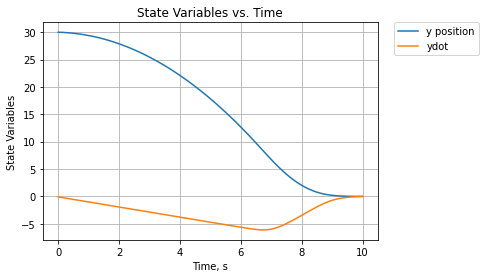

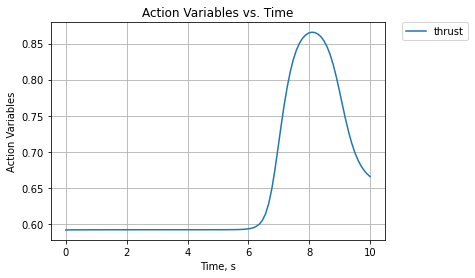

In [8]:
# Now it's time to run the code!

T = 100  # number of time steps
dim_input = 2  # state space dimensions
dim_hidden = 6  # latent dimensions
dim_output = 1  # action space dimensions
d = Dynamics()  # define dynamics
c = Controller(dim_input, dim_hidden, dim_output)  # define controller
s = Simulation(c, d, T)  # define simulation
o = Optimize(s)  # define optimizer
o.train(40)  # solve the optimization problem